# Guppy Tutorial


## Bell and GHZ states

Let's start by defining a simple quantum function to prepare the Bell state.

$$
| \Phi^+\rangle = \frac{1}{\sqrt{2}}\Big(|00\rangle + |11\rangle\Big)
$$


Reminder... We can think of the $|0\rangle$ state as a column vector $\begin{pmatrix} 1 \\ 0\end{pmatrix}$ and $|1\rangle$ as $\begin{pmatrix} 0 \\ 1\end{pmatrix}$

The multi qubit states $|00\rangle$ and $|11\rangle$ are 

$$
|00\rangle = \begin{pmatrix} 1 \\ 0\end{pmatrix} \otimes \begin{pmatrix} 1 \\ 0\end{pmatrix} = \begin{pmatrix} 1 *\begin{pmatrix} 1 \\ 0\end{pmatrix}\\ 0 * \begin{pmatrix} 1 \\ 0\end{pmatrix}\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\0 \end{pmatrix}
$$

$$
|11\rangle = \begin{pmatrix} 0 \\ 1\end{pmatrix} \otimes \begin{pmatrix} 0 \\ 1\end{pmatrix} = \begin{pmatrix} 0 *\begin{pmatrix} 0 \\ 1\end{pmatrix}\\ 1 * \begin{pmatrix} 0 \\ 1\end{pmatrix}\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \\1 \end{pmatrix}
$$



We don't need any advanced Guppy features for this. In fact a Bell state can be prepared with a simple quantum circuit.


<p align="center">
  <img src="images/bell_circuit.png" width="400">
</p>



The $H$ and CX gate are defined as follows...






$$
\begin{equation}
\text{H} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\,, 
\quad
\text{CX} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}
$$

These gates have the following action

$$
\begin{equation}
H|0\rangle = \frac{1}{\sqrt{2}} \Big( |0\rangle + |1\rangle\Big)\,,\quad H|1\rangle =  \frac{1}{\sqrt{2}}\Big(|0\rangle - |1\rangle\Big) 
\end{equation}
$$

The CX gate acts on two qubits at once. It flips the target qubit if and only if the first qubit is in the $|1\rangle$ state and otherwise acts as the identity.

$$
\begin{align}
CX|00\rangle &= |00\rangle \\
CX|01\rangle &= |01\rangle \\
CX|10\rangle &= |11\rangle \\
CX|11\rangle &= |10\rangle 
\end{align}
$$




In [1]:
from guppylang import guppy
from guppylang.std.quantum import cx, h, qubit, measure_array
from guppylang.std.builtins import result, array


@guppy
def prepare_bell() -> array[qubit, 2]:
    q0, q1 = qubit(), qubit()  # allocate qubits
    h(q0)  # apply Hadamard gate
    cx(q0, q1)  # Apply CX gate
    return array(q0, q1)  # return qubits to outer scope


prepare_bell.check()  # Type check our Guppy function

In [2]:
@guppy
def main() -> None:
    qs = prepare_bell()
    result("c", measure_array(qs))

Remember in quantum mechanics, measurement is probabilistic. The probability of measuring the Bell state in $|00\rangle$ is given by

$$
P_{00} = \Big|\langle 00 \Big| \frac{1}{\sqrt{2}} \Big( |00\rangle + |11\rangle \Big)\Big|^2 = \Big|\frac{1}{\sqrt{2}}\Big|^2 = \frac{1}{2}
$$

Likewise

$$
P_{11} = \frac{1}{2} 
$$


In [3]:
n_shots = 1000
sim_result = main.emulator(n_qubits=2).with_seed(1).with_shots(n_shots).run()



We therefore obtain measurement results in the $|00\rangle$ and $|11\rangle$ states with equal probability. What do we get if we execute our program for 1000 shots?

In [4]:
print(sim_result.register_counts())

{'c': Counter({'00': 515, '11': 485})}


Let's plot the results of these 1000 shots using matplotlib

In [5]:
from guppylang.emulator.result import QsysResult
import matplotlib.pyplot as plt


def plot_results(
    sim_result: QsysResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 800,
) -> None:
    counts_dict = sim_result.register_counts()["c"]
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [
        "|" + str(entry[0]) + ">" for entry in n_most_common_strings
    ]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts

    if dark_mode:
        plt.style.use("dark_background")

    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.4, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

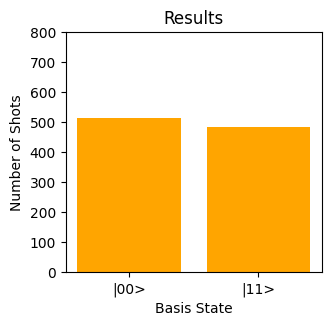

In [6]:
plot_results(sim_result)

What about a generalised Bell state? 

$$
|\text{GHZ}\rangle^{(n)} = \frac{1}{\sqrt{2}}\Big(|0\rangle^{\otimes n} + |1\rangle^{\otimes n} \Big)
$$

for four qubits

$$
|\text{GHZ}\rangle^{(4)} = \frac{1}{\sqrt{2}}\Big(|0000\rangle + |1111\rangle \Big)
$$

In [7]:
N = guppy.nat_var("N")


@guppy
def prepare_ghz_state(qubits: array[qubit, N]) -> None:
    h(qubits[0])
    for i in range(len(qubits) - 1):
        cx(qubits[i], qubits[i + 1])

In [8]:
prepare_ghz_state.check()

In [9]:
@guppy
def main() -> None:
    qubits = array(qubit() for _ in range(4))
    prepare_ghz_state(qubits)
    result("c", measure_array(qubits))


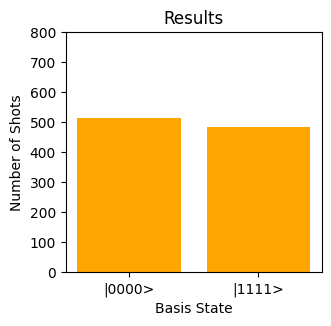

In [10]:
n_shots = 1000
sim_result_ghz = main.emulator(n_qubits=4).with_seed(1).with_shots(n_shots).run()

plot_results(sim_result_ghz)

## Ownership rules


Operations which borrow qubits -> unitary quantum gates (Hadamard, CX)

Operations which consume qubits -> `measure`, `discard` etc.

As mentioned, Guppy is a compiled language and enforces "ownership rules" at compile time. These ownership rules are inspired by Rust, a modern programming language which emphasizes type safety.

Guppy ownership rules give the following safety guarantees.


1. Qubits cannot be used after they are destructively measured or discarded.
2. A multi-qubit gate cannot use the same qubit more than once no (`cx(q0, q0)`).
3. It is impossible to implicitly discard or leak qubits (no idling qubits).

In [11]:
@guppy
def implicit_discard() -> None:
    q = qubit()  # Allocated qubit is not consumed
    h(q)


implicit_discard.check()  # Check fails :(

Error: Drop violation (at <In[11]>:3:4)
  | 
1 | @guppy
2 | def implicit_discard() -> None:
3 |     q = qubit()  # Allocated qubit is not consumed
  |     ^ Variable `q` with non-droppable type `qubit` is leaked

Help: Make sure that `q` is consumed or returned to avoid the leak

Guppy compilation failed due to 1 previous error


In [ ]:
@guppy
def prepare_plus() -> qubit:
    q1 = qubit()
    h(q1)
    return q1  # return ownership of q to the caller


prepare_plus.check()  # Check succeeds :)

In [ ]:
from guppylang.std.quantum import measure


@guppy
def prepare_and_measure() -> None:
    q = qubit()
    h(q)
    measure(q)  # consume the qubit q


prepare_and_measure.check()  # Check succeeds :)

## Hadamard test example

Consider the following implementation of the Hadamard test where we want to compute the expectation value of $Y$.

![alt text](./images/CY_circ.png "Title")

In this simple program the expectation value of $Y$ can be related to the probability of measuring the first qubit in the $|0\rangle$ or $|1\rangle$ state.

$$
P_{|0\rangle} = \frac{1 + \langle Y \rangle}{2} \, \quad P_{|1\rangle} = \frac{1 - \langle Y \rangle}{2}
$$

*Exercise:* Can you derive this formula relating the probability of measuring 0 or 1 to the expectation value of $Y$?

We can write a simple Guppy program to implement this test estimating $\langle Y \rangle$

In [ ]:
from guppylang.std.quantum import cy, discard


@guppy
def main() -> None:
    a, q = qubit(), qubit()  # Allocate two qubits
    h(a)
    cy(a, q)

    # Measure ancilla in X-basis
    h(a)
    c0 = measure(a)
    discard(q)
    result("c[0]", c0)  # Get the result of measuring the ancilla


main.check()  # Check fails :(

In [ ]:
@guppy
def borrow_consumed() -> None:
    q = qubit()
    h(q)
    measure(q)
    h(q)  # Applying a gate to a consumed qubit doesn't work


borrow_consumed.check()  # Check fails :(

## T state injection


<p align="center">
  <img src="images/t_state_injection.png" width="600">
</p>

In [ ]:
from guppylang.std.quantum import t, s, x, discard
from guppylang.std.debug import state_result


@guppy
def inject_t(q: qubit) -> None:
    a = qubit()
    h(a)
    t(a)
    cx(a, q)

    if measure(a):
        x(q)
        s(q)


@guppy
def main() -> None:
    q = qubit()
    h(q)
    inject_t(q)
    result("t", measure(q))


In [ ]:
shots = main.emulator(n_qubits=4).statevector_sim().with_seed(42).with_shots(500).run()

In [ ]:
print(shots.register_counts()["t"])

## Postselection

In this example we will demonstrate the early-exit capabilities of Guppy.

To do this we will have a program which prepares the $|\bar{0}\rangle$ state for the $[[7, 1, 3]]$ Steane code. This program will be subject to some quantum noise. We can ensure that the preparation of the $|\bar{0}\rangle$ state is fault-tolerant by measuring some ancilla qubits and exiting the program if an error is detected.


$$
\begin{equation}
|0_L\rangle = \frac{1}{\sqrt{8}}\big(
|0000000\rangle + 
|1010101\rangle + 
|0110011\rangle + 
|1100110\rangle + 
|0001111\rangle + 
|1011010\rangle + 
|0111100\rangle + 
|1101001\rangle
\big)
\end{equation}
$$

Basic experiment

1. Attempt to encode $|0\rangle$
2. Check for errors with ancilla measurements
3. If an error is detected, exit and try again.

Let's define a `SteaneQubit` struct which encapsulates a single logical qubit in the Steane code. This logical qubit is encoded in seven physical qubits.

In [ ]:
@guppy.struct
class SteaneQubit:
    data_qs: array[qubit, 7]

Now we can build a simple quantum program to prepare the $|\bar{0}\rangle$ state. 

In [ ]:
@guppy
def non_ft_zero() -> SteaneQubit:
    data_qubits = array(qubit() for _ in range(7))
    plus_ids = array(0, 4, 6)
    for i in plus_ids:
        h(data_qubits[i])

    cx_pairs = array((0, 1), (4, 5), (6, 3), (6, 5), (4, 2), (0, 3), (4, 1), (3, 2))
    for c, t in cx_pairs:
        cx(data_qubits[c], data_qubits[t])
    return SteaneQubit(data_qubits)

Now we can make our state preparation fault-tolerant by adding some ancilla qubits which interact with our seven encoding qubits. If we measure these ancillas and detect an error, we can exit the program.

In [ ]:
from guppylang.std.builtins import exit


@guppy
def ft_zero() -> SteaneQubit:
    q = non_ft_zero()
    ancilla = qubit()
    flags = array(1, 3, 5)
    for f in flags:
        cx(q.data_qs[f], ancilla)
    if measure(ancilla):
        exit("Postselected: FT prep failed", 1)
    return q

Next we need a noise model. Here we will construct an artifical depolarizing channel for execution on Selene.

In [ ]:
from selene_sim import DepolarizingErrorModel

error_model = DepolarizingErrorModel(
    random_seed=1234,
    # single qubit gate error rate
    p_1q=1e-3,
    # two qubit gate error rate
    p_2q=1e-3,
    # set state preparation and measurement error rates to 0
    p_meas=0,
    p_init=0,
)

Finally we can run our program on Selene with our error model and analyse the results.

In [ ]:
from guppylang.defs import GuppyFunctionDefinition
from typing import Counter


def run(main_def: GuppyFunctionDefinition) -> Counter:
    res = (
        main_def.emulator(n_qubits=8)
        .stabilizer_sim()
        .with_seed(42)
        .with_shots(1000)
        .with_error_model(error_model)
        .with_progress_bar()
        .run()
    )

    return res.collated_counts()

In [ ]:
n = guppy.nat_var("n")


@guppy
def parity_check(data_bits: array[bool, n]) -> bool:
    out = False
    for i in range(n):
        out ^= data_bits[i]
    return out

In [ ]:
@guppy
def main() -> None:
    steane_q = ft_zero()

    # Measure the data qubits
    data = measure_array(steane_q.data_qs)
    result("parity", parity_check(data))


run(main)

## Thanks for listening!

Check out the docs and tutorials on the Guppy website! https://guppylang.org


<p align="center">
  <img src="images/guppy_site_qr.png" width="200">
</p>

Check out the source code on Github! https://github.com/CQCL/guppylang

Contributions welcome :) look for "good first issue"


<p align="center">
  <img src="images/github_site_qr.png" width="200" style="margin-right: 20px;">
  <img src="images/repo_screenshot.png" width="500">
</p>